## Tutorial 4: off-line learning the Q-values of the Kennedy receiver ##

In [295]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random


def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn

def ps_maxlik(beta):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    p=0
    for n1 in [0,1]:
       p+=Prob(np.sign(beta)*(-1)**(n1)*alpha, beta, n1)
    return p/2


### what we wanna learn ###

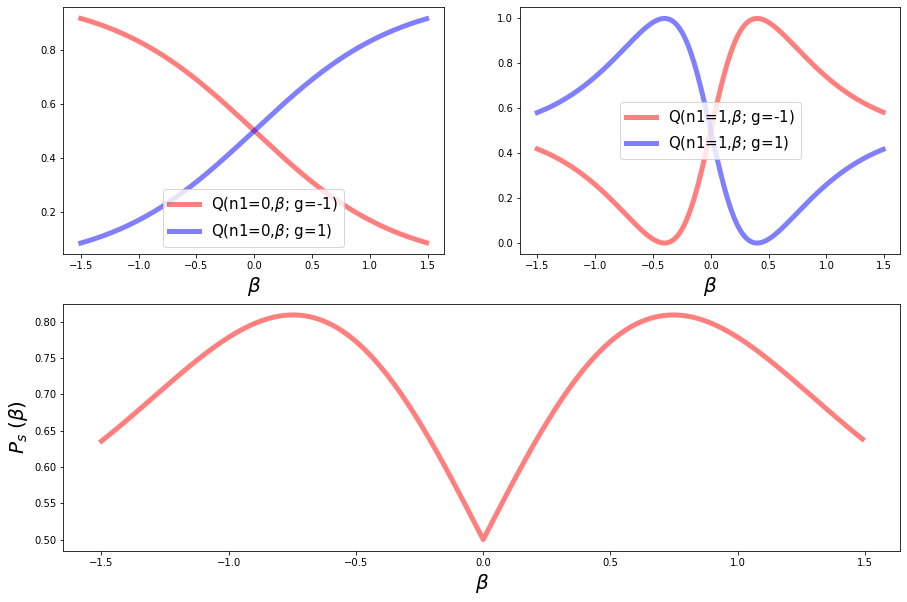

In [5]:


plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((2,2),(0,0))
ax2 =  plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

betas = np.arange(-1.5,1.5,.01)
ax3.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red", linewidth=5)
ax3.set_xlabel(r'$\beta$', size=20)
ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


### So we create the dataset, notice now we return almost pre-processed ###

In [260]:
class DataSet():
    def __init__(self, size=10**3, nbetas=10):
        #rpbgo = rewards per beta-guess-outcome
        self.size = size
        self.amplitude = 0.4
        self.betas = np.linspace(-1.5, 1.5,nbetas)
        
        #d = {"a0":[], "h1-a1":[], "r2":[]}
        d=[]
        for episode in range(size):
            beta = np.random.choice(self.betas,1)[0]
            proboutcome = Prob(self.amplitude,beta,0)
            outcome = np.random.choice([0.,1.],1,p=[proboutcome, 1-proboutcome])[0]
            guess = np.random.choice([-1,1],1)[0]
            mean_bernoulli = qval(beta, outcome, guess)
            reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
            
            d.append([beta,outcome,guess,reward])
            #d["a0"].append([beta])
            #d["h1-a1"].append([beta, outcome, guess])
            #d["r2"].append(reward)
        self.data_unsplitted=np.array(d)
        #self.data_unsplitted = {}
        #for k in d.keys():
         #   self.data_unsplitted[k] = np.array(d[k])
    def sample_minibatch(self, bs):
        #samples a minibatch of full history of transitions: a0 -> h0 -> a1 -> h1 -> r2.
        #returns a random sample of {a0}, {h1-a1}, {r2} ordered!
        d = self.data_unsplitted[np.random.choice(np.arange(self.size),int(bs),replace=False)]
        a0s = d[:,0]
        h0s_a1s = d[:,[0,1,2]]
        r2s = d[:,3]
        return a0s, h0s_a1s, r2s
    
    def give_epoch(self, bs):
        #gives a list of batches that form an epoch
        epoch=[]
        for k in range(int(self.size/bs)):
            epoch.append(self.sample_minibatch(bs))
        return epoch
    
    def BatchSizeSplit(self, dataset,batch_size):
        #not useful here
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])


### Let's see if things are done well.. ###

In [291]:
dataset = DataSet(10**3)
betas_done = pd.Series(dataset.data_unsplitted[:,0])
betas_done.hist()

In [304]:
epoch = dataset.give_epoch(10)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 100
How big is a batch? how many betas we put per batch? 10


In [305]:
epoch = dataset.give_epoch(100)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 10
How big is a batch? how many betas we put per batch? 100


In [306]:
epoch = dataset.give_epoch(1000)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 1
How big is a batch? how many betas we put per batch? 1000


### Define the networks ###

In [307]:

class Net(tf.keras.Model):
    #input_dim: 1 if layer=0, 3 if layer= 2, for the Kennedy receiver ##
    def __init__(self, input_dim, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(input_dim,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [96]:
## now let's define the training loop ##

In [308]:
def calculate_greedy_from_batch(net1, batch):
    labels_net0=[]
    for k in batch[1][:,[0,1]]:
        q_s_all_actions=[]

        for guess in [-1.,1.]:
            gg=[]
            gg = np.append(gg, np.append(k,guess))
            q_s_all_actions.append([gg])
        labels_net0.append(np.max(np.squeeze(net_1(np.array(q_s_all_actions)))))
    return np.expand_dims(labels_net0,axis=1)

### this function may be crazy, but it's just to plot the predictions of the second network ##

In [ ]:
def plot_predictions(histo_preds, losses, title=None):

    plt.figure(figsize=(25,20))
    ax1 =  plt.subplot2grid((2,3),(0,0))
    ax2 =  plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(1,0), colspan=2)
    ax4 = plt.subplot2grid((2,3),(0,2))
    ax5 = plt.subplot2grid((2,3),(1,2))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red", linewidth=5)
    ax3.set_xlabel(r'$\beta$', size=20)
    ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

    betas_train = dataset.betas
    for predictions in histo_preds["net_1"].values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.25, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.25,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

    
    ### we do the same for ax3:
    
    for predictions in histo_preds["net_0"].values():
        ax3.plot(betas_train,predictions["values"],alpha=0.25, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")

    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")


    for ax in [ax1, ax2,ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        #ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
        
     #### not plot the losses"####   
    for ax, loss in zip([ax4,ax5],losses):
        ax.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

        ax.set_xlabel("epoch", size=20)
        ax.set_ylabel("Loss",size=20)
    return

In [346]:
def supervised_training(batch_size=32., total_epochs=30, buffer_size=10**4):

    net_0 = Net(input_dim=1)
    net_1 = Net(input_dim=3)

    net_0(np.array([[0.],[1.]])) #initialize the network 0, arbitrary inputs.
    net_1(np.array([[0.,1.,1.]]))

    optimizer_0 = tf.keras.optimizers.Adam(lr=0.001/2.)
    optimizer_1 = tf.keras.optimizers.Adam(lr=0.001/2.)

    dataset = DataSet(size=buffer_size)
    histo_preds = {"net_0":{}, "net_1":{}} #here i save the predictions

    loss_0_ev, loss_1_ev = [], []
    for epoch_number in tqdm(range(total_epochs)):
        epoch = dataset.give_epoch(batch_size)
        loss_0_avg, loss_1_avg = [], []

        for batch in tqdm(epoch):
            labels_net0 = calculate_greedy_from_batch(net_1, batch )
            labels_net1 = np.expand_dims(batch[2],axis=1)
            with tf.GradientTape() as tape:
                tape.watch(net_0.trainable_variables)
                preds0 = net_0(np.expand_dims(batch[0],axis=1))
                loss_0 = tf.keras.losses.MSE(labels_net0,preds0)
                loss_0 = tf.reduce_mean(loss_0)
                grads0 = tape.gradient(loss_0, net_0.trainable_variables)
                optimizer_0.apply_gradients(zip(grads0, net_0.trainable_variables))
            with tf.GradientTape() as tape:
                tape.watch(net_1.trainable_variables)
                preds1 = net_1(batch[1])
                loss_1 = tf.keras.losses.MSE(labels_net1,preds1)
                loss_1 = tf.reduce_mean(loss_1)
                grads1 = tape.gradient(loss_1, net_1.trainable_variables)
                optimizer_1.apply_gradients(zip(grads1, net_1.trainable_variables))
            loss_0_avg.append(loss_0)
            loss_1_avg.append(loss_1)

        ### save the average losses per epoch###
        mean_loss_0 = np.mean(loss_0_avg)
        mean_loss_1 = np.mean(loss_1_avg)
        loss_0_ev.append(mean_loss_0)
        loss_1_ev.append(mean_loss_1)

        ### save the network's prediction at each epoch ###
        for nett in ["net_0","net_1"]:

            histo_preds[nett][str(epoch_number)] ={} 
            histo_preds[nett][str(epoch_number)]["epoch_number"] = epoch_number
            histo_preds[nett][str(epoch_number)]["values"] = {}

        histo_preds["net_0"][str(epoch_number)]["values"] = np.squeeze(net_0(np.expand_dims(dataset.betas,axis=1)))

        index=0
        for n1 in [0.,1.]:
            for guess in [-1.,1.]:
                foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                histo_preds["net_1"][str(epoch_number)]["values"][str(index)] = np.squeeze(net_1(foo))
                index+=1

        print("#### \nepoch: {}\nloss_0: {}\nloss_1: {}\n \n***********\n".format(epoch_number,mean_loss_0,mean_loss_1))
    losses = [loss_0_ev, loss_1_ev]
    return histo_preds, losses

In [349]:
histo_preds, losses = supervised_training(batch_size=500, total_epochs=40, buffer_size=10**4)

#### 
epoch: 0
loss_0: 0.02135150030018808
loss_1: 0.24925706622745047
 
***********



#### 
epoch: 1
loss_0: 0.017441166384990194
loss_1: 0.24780770407387426
 
***********



#### 
epoch: 2
loss_0: 0.012454696913413426
loss_1: 0.24537666028257857
 
***********



#### 
epoch: 3
loss_0: 0.007007820395174958
loss_1: 0.24087816651124064
 
***********



#### 
epoch: 4
loss_0: 0.003932249608901961
loss_1: 0.23583747147161574
 
***********



#### 
epoch: 5
loss_0: 0.0033757475952974126
loss_1: 0.23197383349751624
 
***********



#### 
epoch: 6
loss_0: 0.0032934586430368347
loss_1: 0.2319179406513548
 
***********



#### 
epoch: 7
loss_0: 0.003308003544929758
loss_1: 0.2302266828260849
 
***********



#### 
epoch: 8
loss_0: 0.0032481931384266876
loss_1: 0.22803257764277235
 
***********



#### 
epoch: 9
loss_0: 0.003227333965598436
loss_1: 0.2226822281445855
 
***********



#### 
epoch: 10
loss_0: 0.003313939136442794
loss_1: 0.22392421653341063
 
***********



#### 
epoch: 11
loss_0: 0.0032998362049749008
loss_1: 0.21798847973379232
 
***********



#### 
epoch: 12
loss_0: 0.0031442305931697625
loss_1: 0.21653229599665727
 
***********



#### 
epoch: 13
loss_0: 0.0031284940782986903
loss_1: 0.21626934309144147
 
***********



#### 
epoch: 14
loss_0: 0.0030992399569972676
loss_1: 0.2091891765457595
 
***********



#### 
epoch: 15
loss_0: 0.0032184206656151225
loss_1: 0.20647835372216056
 
***********



#### 
epoch: 16
loss_0: 0.003111220890155059
loss_1: 0.20594001135579507
 
***********



#### 
epoch: 17
loss_0: 0.0031805599594270833
loss_1: 0.2038479411198218
 
***********



#### 
epoch: 18
loss_0: 0.0031587792681952915
loss_1: 0.20306802433026044
 
***********



#### 
epoch: 19
loss_0: 0.0031771564104573135
loss_1: 0.2001131510652733
 
***********



#### 
epoch: 20
loss_0: 0.0031197481519411804
loss_1: 0.19766831358417858
 
***********



#### 
epoch: 21
loss_0: 0.003183965590782554
loss_1: 0.19316890976448434
 
***********



#### 
epoch: 22
loss_0: 0.003077481136461091
loss_1: 0.19776816375890624
 
***********



#### 
epoch: 23
loss_0: 0.003107635786088059
loss_1: 0.19353716795205891
 
***********



#### 
epoch: 24
loss_0: 0.0031110413670767515
loss_1: 0.19303964597216292
 
***********



#### 
epoch: 25
loss_0: 0.0029322968322014155
loss_1: 0.19335262323309013
 
***********



#### 
epoch: 26
loss_0: 0.003098460701001099
loss_1: 0.1891273520348206
 
***********



#### 
epoch: 27
loss_0: 0.003099521450763168
loss_1: 0.1935731871500695
 
***********



#### 
epoch: 28
loss_0: 0.0031519919074982513
loss_1: 0.19511953982934613
 
***********



#### 
epoch: 29
loss_0: 0.0030520333081799026
loss_1: 0.1912810433644338
 
***********



#### 
epoch: 30
loss_0: 0.003086432608058804
loss_1: 0.1890699027791341
 
***********



#### 
epoch: 31
loss_0: 0.0030537868143361733
loss_1: 0.19300014679269922
 
***********



#### 
epoch: 32
loss_0: 0.0030716466602022973
loss_1: 0.19149910066485076
 
***********



#### 
epoch: 33
loss_0: 0.0031242039157368708
loss_1: 0.19244343395907199
 
***********



#### 
epoch: 34
loss_0: 0.00290255377871675
loss_1: 0.18965538447752397
 
***********



#### 
epoch: 35
loss_0: 0.0029944843626357248
loss_1: 0.1913519278187866
 
***********



#### 
epoch: 36
loss_0: 0.0029468696120952607
loss_1: 0.19176593498068553
 
***********



#### 
epoch: 37
loss_0: 0.0029658767652672624
loss_1: 0.1906051201633376
 
***********



#### 
epoch: 38
loss_0: 0.002978733603102898
loss_1: 0.191847959642506
 
***********



#### 
epoch: 39
loss_0: 0.002895056459672126
loss_1: 0.18923574753102157
 
***********



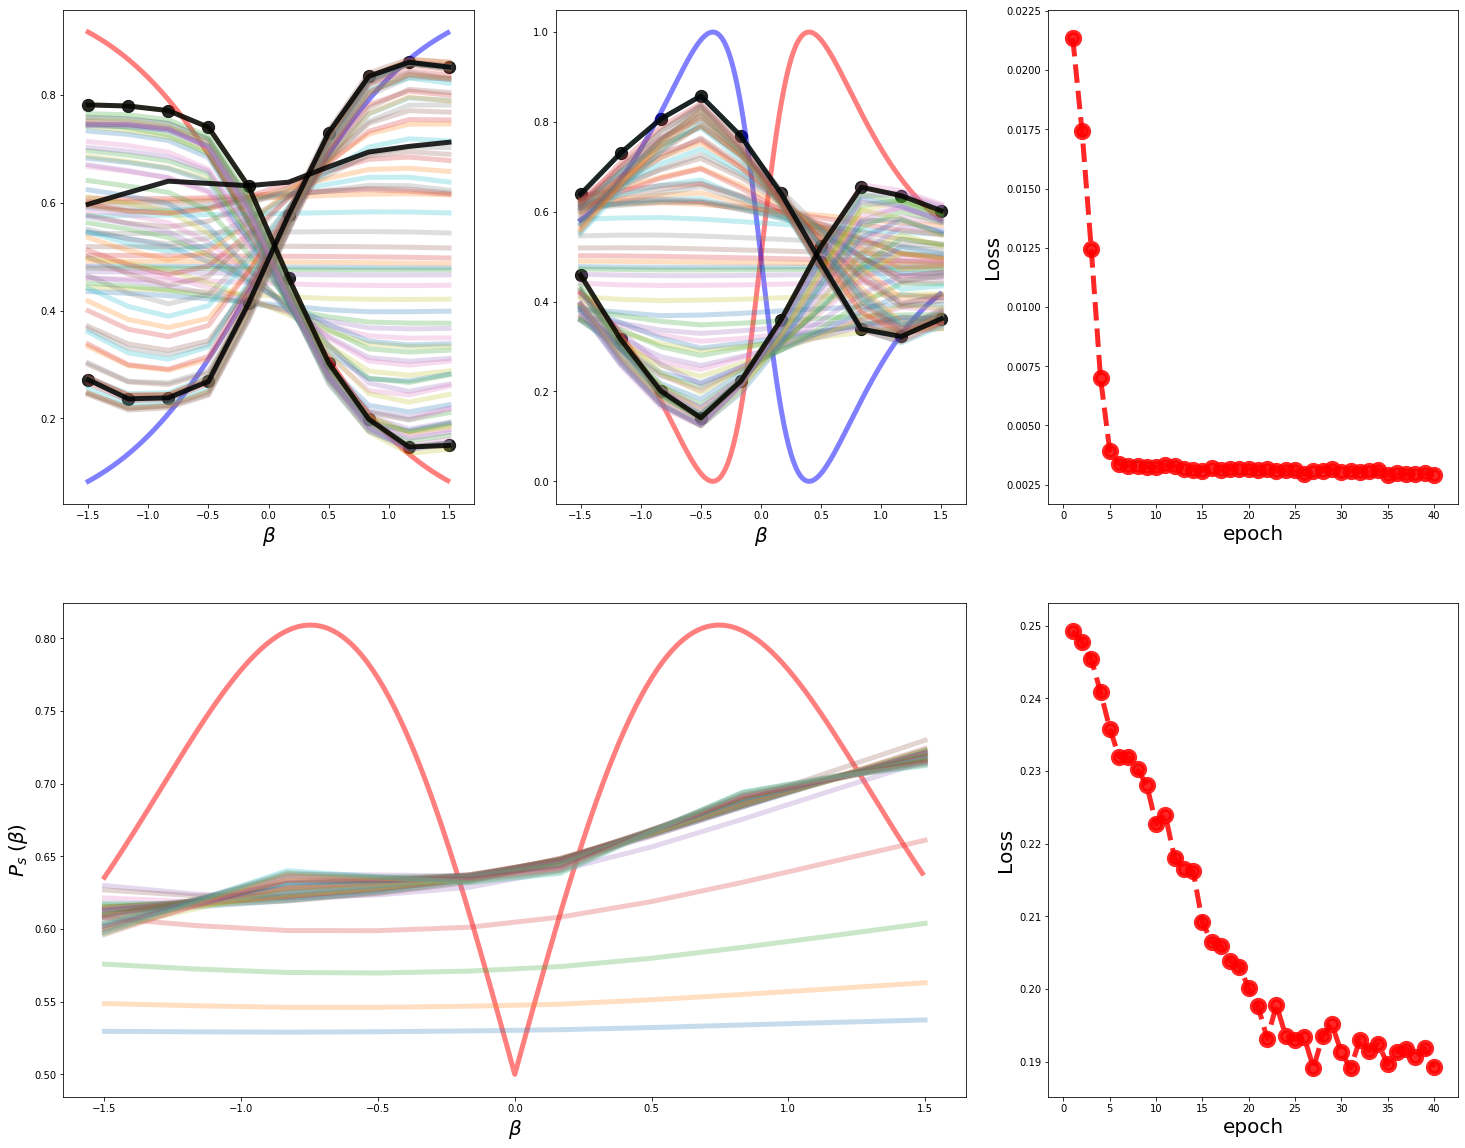

In [350]:
plot_predictions(histo_preds, losses)